Binary classification problem in which our main ojective is to be able predict if a transaction is fraudalent or not depending on severalother variables and information.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
import gc
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
import time
import datetime
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
from catboost import CatBoostRegressor, CatBoostClassifier

folder_path = "../ieee-fraud-detection/"
path = os.getcwd()
categorical_data = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16',
                    'id_17', 'id_18', 'id_19', 'id_20', 'id_21',
                    'id_22', 'id_23', 'id_24', 'id_25', 'id_26',
                    'id_27', 'id_28', 'id_29'] 

categorical_data_client_device_info = ['id_30', 'id_31','id_32','id_33', 'id_34','id_35', 'id_36','id_37', 'id_38','DeviceType', 'DeviceInfo']

categorical_data_cards = ['ProductCD', 'card4', 'card6', 'M4', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']

categorical_data_domain = ['P_emaildomain', 'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2']


In [2]:
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
train_transaction.head()


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [4]:
test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')
test_transaction.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
test_identity.head()

,TransactionID,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,...,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


In [34]:
sub = pd.read_csv(f'{folder_path}sample_submission.csv')
sub.head()

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5


In [6]:
"""
-------------------------------------------------------------------------
Function: data_merge(path, set_1, set_2, data_class)

Purpose: Merge the transaction df and the identity df. The purpose of having
        them together is to be able to work with one df for train and
        another df for testing purposes.

Explanation:
        - Create pandas df for identity table
        - Create pandas df for transcation table
        - Merge both dfs
Parameters: 
            Path, String, folder path to where my dfs are
            set_1, string, name of the data set
            set_2, string, name of the second data set
            data_class, string, name of what the data set will eb

Returns:
            df, dataframe, dataframe that has both transaction & identity values 
-------------------------------------------------------------------------
"""

def data_merge(path, set_1, set_2, data_class):
    identity = pd.read_csv(f'{folder_path}' + set_1)
    transaction = pd.read_csv(f'{folder_path}' + set_2)
    merge_data = pd.merge(identity, transaction, on='TransactionID', how = 'left')
    print (f'{data_class} dataset has {merge_data.shape[0]} rows and columns {merge_data.shape[1]}')
    return merge_data

In [7]:
train = data_merge(path, 'train_identity.csv', 'train_transaction.csv', 'Train')
print(f'The are {train.isnull().any().sum()} columns in train dataset with missing values')

Train dataset has 144233 rows and columns 434
The are 412 columns in train dataset with missing values


In [8]:
train.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionID')['isFraud']
print(y)

0         0
1         0
2         0
3         0
4         0
         ..
144228    0
144229    1
144230    0
144231    0
144232    0
Name: isFraud, Length: 144233, dtype: int64


In [10]:
test = data_merge(path, 'test_identity.csv', 'train_transaction.csv', 'Test')
print(f'The are {test.isnull().any().sum()} columns in test dataset with missing values')

Test dataset has 141907 rows and columns 434
The are 431 columns in test dataset with missing values


In [11]:
test.head()

,TransactionID,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


What are the meaning of these variables?

TRANSACTION TABLE
Categorical Features:
- TransactionDT: timedelta from a given reference datetime 
             (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, 
               card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be 
          associated with the payment card, etc. The actual meaning 
          is masked.
- D1-D15: timedelta, such as days between previous transaction, 
          etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, 
        counting, and other entity relations.

IDENTITY TABLE
Variables in this table are identity information – network 
connection information (IP, ISP, Proxy, etc) and digital 
signature (UA/browser/os/version, etc) associated with 
transactions.
They're collected by Vesta’s fraud protection system and digital 
security partners.
(The field names are masked and pairwise dictionary will not be 
provided for privacy protection and contract agreement)

Categorical Features:
DeviceType
DeviceInfo
id_12 - id_38

Before understanding what model to use it is important to know:
1. What type of data do we have?


In [12]:
'''
-------------------------------------------------------------------------
Function: explore_contionus_data(col)

Purpose: The point of this function is to be able to understand 
         the indentity information. Id_01 - Id_11 are continous
         values

Explanation:
        1. Why we use a histogram?
            - Histograms are very good graphs at depicting continous dfs
        
        2. Counting parameters?
            - We need to count the amount of each type of data type

Parameters: col, string, column name

Return: True, this is just for formality 
-------------------------------------------------------------------------
'''
def explore_contionus_data(col):
    plt.hist(train[col], bins=77)
    plt.title(f'Distribution of {col} variable')
    plt.ylabel('Quantity')
    plt.xlabel('Value Type')
    plt.show()
    print(f'Metrics for col {col}')
    print(train[col].value_counts(dropna=False, normalize=True).head())
    print('--------------------------------------------------------------')
    return True

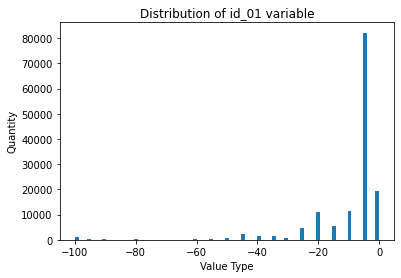

Metrics for col id_01
-5.0     0.569703
 0.0     0.135579
-10.0    0.078047
-20.0    0.077728
-15.0    0.039339
Name: id_01, dtype: float64
--------------------------------------------------------------


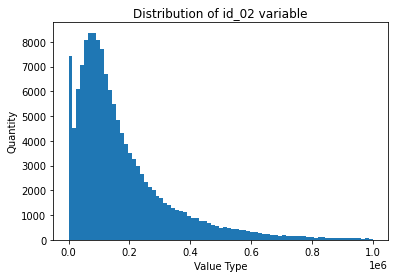

Metrics for col id_02
NaN       0.023303
1102.0    0.000076
696.0     0.000069
1116.0    0.000062
1117.0    0.000062
Name: id_02, dtype: float64
--------------------------------------------------------------


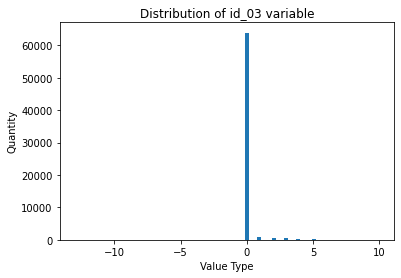

Metrics for col id_03
NaN    0.540161
0.0    0.443054
1.0    0.005983
3.0    0.004631
2.0    0.002919
Name: id_03, dtype: float64
--------------------------------------------------------------


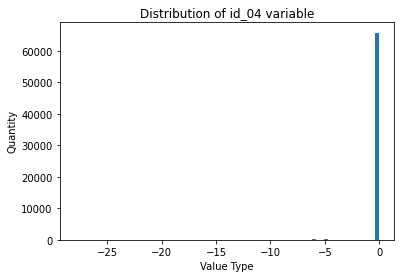

Metrics for col id_04
 NaN    0.540161
 0.0    0.455783
-5.0    0.000915
-6.0    0.000679
-8.0    0.000444
Name: id_04, dtype: float64
--------------------------------------------------------------


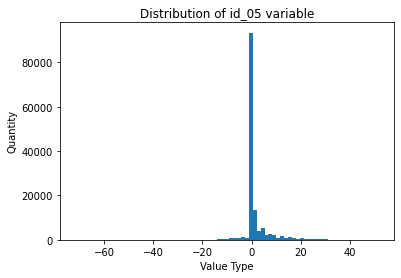

Metrics for col id_05
0.0    0.643008
1.0    0.057497
NaN    0.051084
2.0    0.034229
3.0    0.026721
Name: id_05, dtype: float64
--------------------------------------------------------------


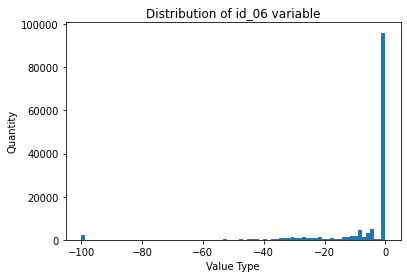

Metrics for col id_06
 0.0    0.633177
 NaN    0.051084
-1.0    0.032496
-5.0    0.026686
-6.0    0.022582
Name: id_06, dtype: float64
--------------------------------------------------------------


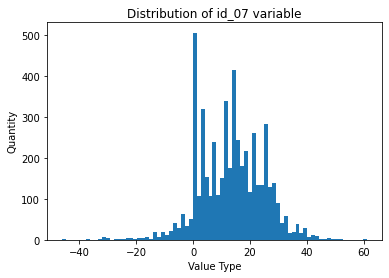

Metrics for col id_07
NaN     0.964259
0.0     0.002836
16.0    0.001699
14.0    0.001581
12.0    0.001442
Name: id_07, dtype: float64
--------------------------------------------------------------


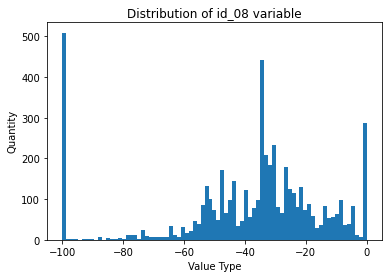

Metrics for col id_08
 NaN      0.964259
-100.0    0.003467
 0.0      0.001810
-34.0     0.001782
-33.0     0.001449
Name: id_08, dtype: float64
--------------------------------------------------------------


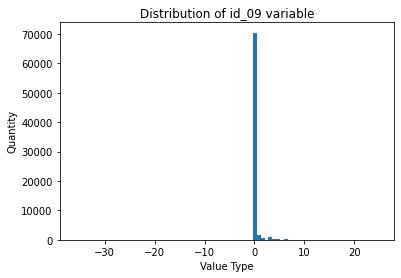

Metrics for col id_09
0.0    0.487947
NaN    0.480521
1.0    0.011204
3.0    0.006697
2.0    0.005359
Name: id_09, dtype: float64
--------------------------------------------------------------


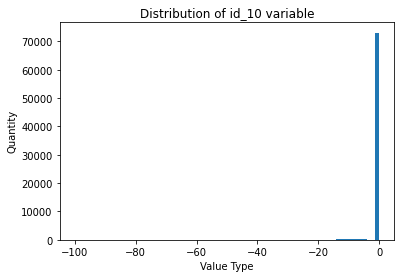

Metrics for col id_10
 0.0    0.505287
 NaN    0.480521
-6.0    0.002045
-5.0    0.001713
-1.0    0.001387
Name: id_10, dtype: float64
--------------------------------------------------------------


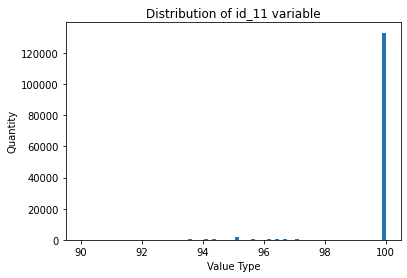

Metrics for col id_11
100.000000    0.923242
NaN           0.022568
95.080002     0.008535
95.160004     0.005228
97.120003     0.003051
Name: id_11, dtype: float64
--------------------------------------------------------------


True

In [13]:
explore_contionus_data('id_01')
explore_contionus_data('id_02')
explore_contionus_data('id_03')
explore_contionus_data('id_04')
explore_contionus_data('id_05')
explore_contionus_data('id_06')
explore_contionus_data('id_07')
explore_contionus_data('id_08')
explore_contionus_data('id_09')
explore_contionus_data('id_10')
explore_contionus_data('id_11')

In [14]:
'''
-------------------------------------------------------------------------
Function: horizontal_col_chart(y_data, x_data, col_type)

Purpose: Create a horizontal data bar

Parameters: y_data, y axis, df
            x_data, x axis, df
            col_type, name of the colum, string

Return: True, this is just for formality 
-------------------------------------------------------------------------
'''
def horizontal_col_chart(y_data, x_data, col_type):
    plt.barh(y_data, x_data)
    plt.show()
    plt.title(f'Counts of {col_type}')
    plt.ylabel('Count')
    plt.xlabel(f'{col_type}')
    return True

'''
-------------------------------------------------------------------------
Function: vertical_col_chart(y_data, x_data, col_type)

Purpose: Create a vertical data bar

Parameters: y_data, y axis, df
            x_data, x axis, df
            col_type, name of the colum, string

Return: True, this is just for formality 
-------------------------------------------------------------------------
'''
def vertical_col_chart(y_data, x_data, col_type):
    plt.bar(y_data, x_data)
    plt.show()
    plt.title(f'Counts of {col_type}')
    plt.ylabel(f'{col_type}')
    plt.yticks(rotation=90)
    plt.xlabel('Count')
    return True

'''
-------------------------------------------------------------------------
Function: explore_categorical_data(data_to_explore)

Purpose: Create a function that can do an analysis of the categorical feature

Explanation:
        - If the Y-axis has more variety of data, make a vertical bar graph
        - If the X-axis has more variety of data, make a horizontal bar graph 

Parameters: data_to_explore, list, list of catergorical data

Return: True, this is just for formality 
-------------------------------------------------------------------------
'''
def explore_categorical_data(data_to_explore):
    for col in data_to_explore:
        feature_count = train[col].value_counts(dropna=False).reset_index().rename(columns={col: 'count', 'index': col})
        y_values = feature_count.iloc[:, 0] 
        y_unique_values = len(y_values.value_counts())
        y_values = [str(y_value) for y_value in y_values]
        x_values = feature_count.iloc[:, 1]
        x_unique_values = len(x_values.value_counts())
        
        if (y_unique_values <= x_unique_values):
            horizontal_col_chart(y_values, x_values, col)
        else:
            vertical_col_chart(y_values, x_values, col)
            
    return True




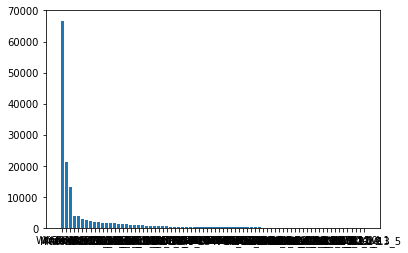

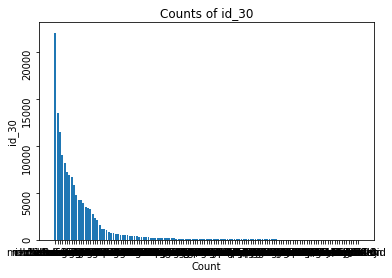

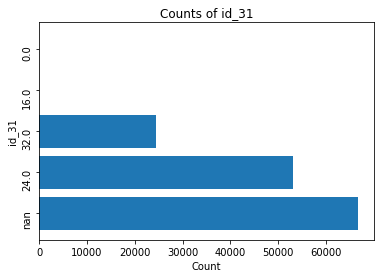

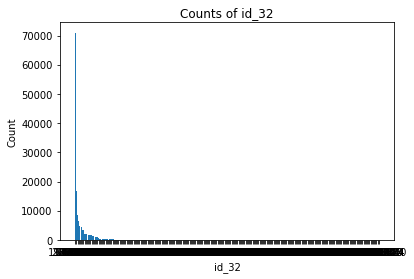

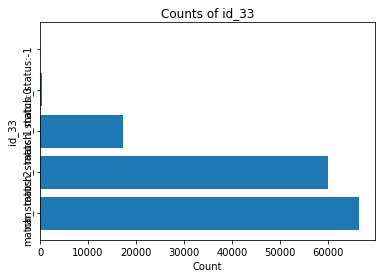

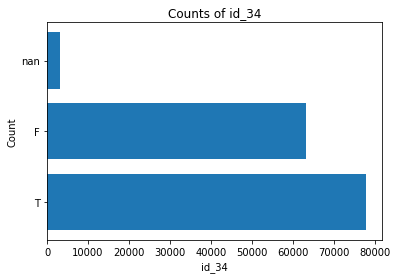

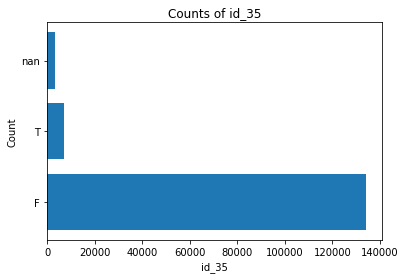

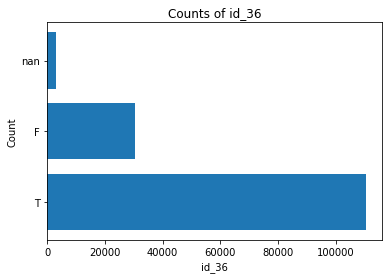

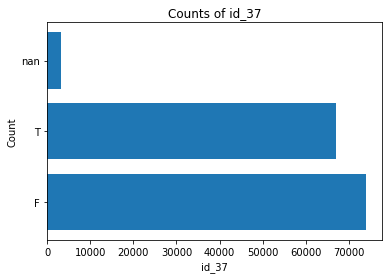

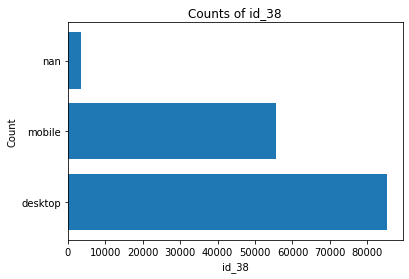

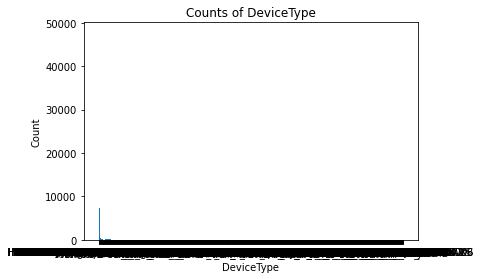

True

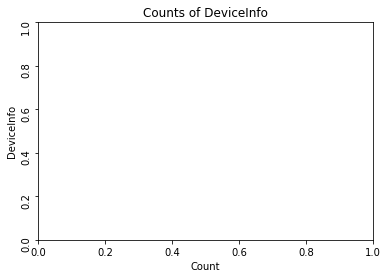

In [15]:
explore_categorical_data(categorical_data_client_device_info)

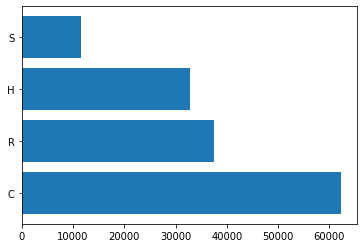

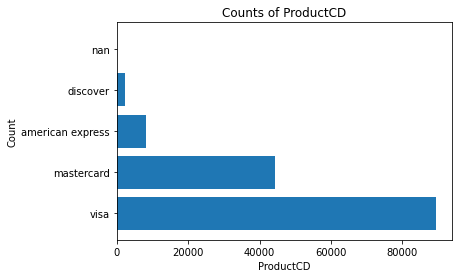

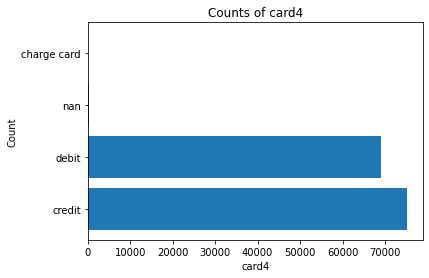

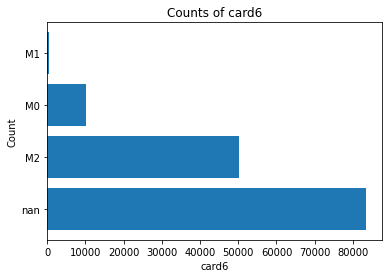

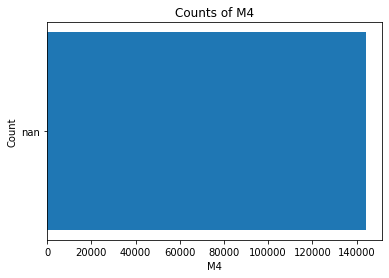

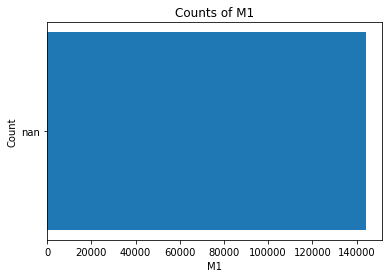

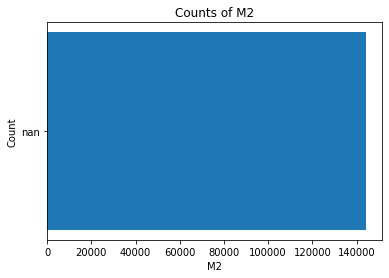

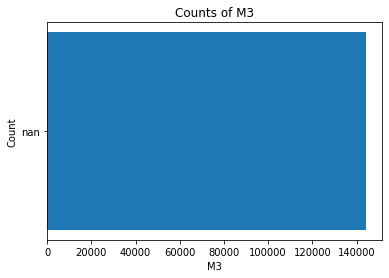

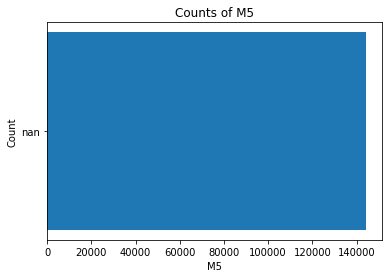

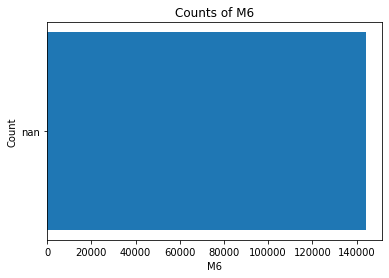

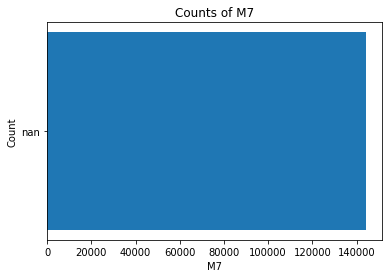

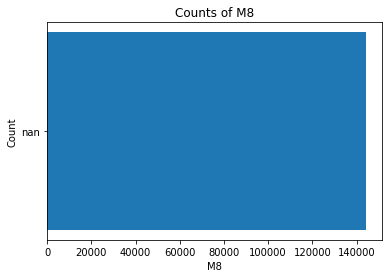

True

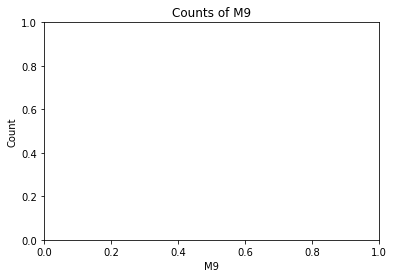

In [16]:
explore_categorical_data(categorical_data_cards)

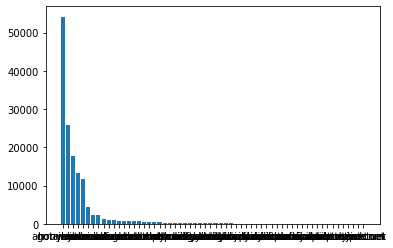

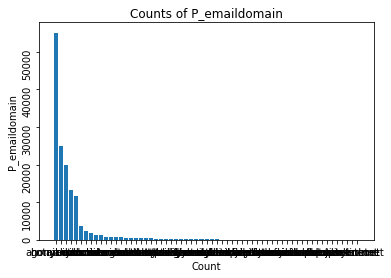

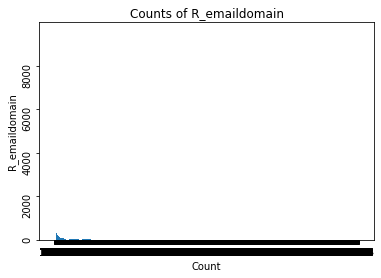

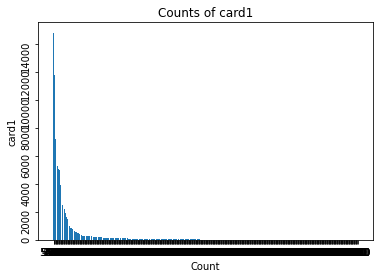

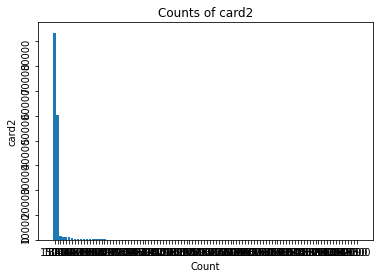

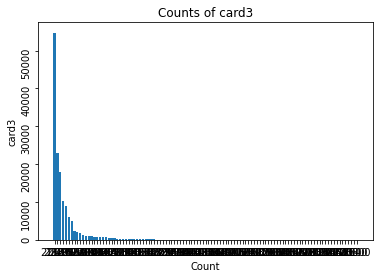

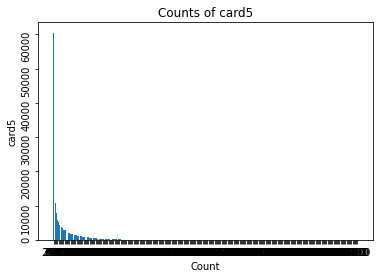

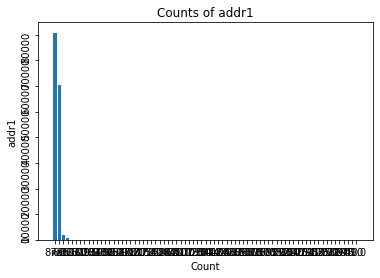

True

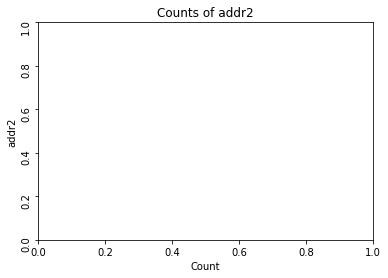

In [17]:
explore_categorical_data(categorical_data_domain)

In [18]:
"""
-------------------------------------------------------------------------
Function: select_noise_cols()

Purpose: Select cols that are noise, most likely to eliminate

Explanation:
        - Pick Cols thata 90% of the values or more are nul 
        - Pick cols that have one value or None
Parameters: 
            None
Returns:
            cols_to_drop, dataframe, dataframe of the values to drop 
-------------------------------------------------------------------------
"""

def select_noise_cols():
    many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
    many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]

    big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
    big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

    one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
    one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]
    
    cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols + one_value_cols_test))
    print('Cols to drop are ', len(cols_to_drop))
    print(cols_to_drop)
    
    return cols_to_drop


In [20]:
drop_cols = select_noise_cols()

Cols to drop are  415
['V224', 'V141', 'V215', 'id-22', 'V154', 'V332', 'V71', 'V18', 'V12', 'V112', 'V333', 'V276', 'V290', 'V136', 'V101', 'C7', 'V3', 'V256', 'V222', 'V135', 'C13', 'V121', 'V63', 'R_emaildomain', 'V339', 'V33', 'V269', 'V9', 'C6', 'V31', 'V24', 'V114', 'V62', 'V25', 'V210', 'V209', 'V67', 'V206', 'V274', 'V14', 'V260', 'V47', 'C14', 'M7', 'V182', 'V303', 'V246', 'V316', 'V64', 'V13', 'V139', 'V185', 'V166', 'V105', 'V297', 'V140', 'V34', 'V331', 'V315', 'V4', 'V90', 'V142', 'id-08', 'D6', 'V15', 'V87', 'V313', 'V320', 'V113', 'V270', 'V2', 'D14', 'V232', 'M8', 'V302', 'V134', 'V92', 'ProductCD', 'D3', 'V278', 'V65', 'V273', 'V295', 'id_27', 'V35', 'V54', 'V41', 'V27', 'D1', 'V277', 'V201', 'V125', 'V268', 'V48', 'V292', 'M4', 'V294', 'V198', 'C10', 'V58', 'V242', 'V137', 'V46', 'V145', 'id_11', 'V107', 'V89', 'V168', 'V99', 'V110', 'C12', 'D15', 'V284', 'V42', 'V296', 'V36', 'id-24', 'V132', 'card1', 'V328', 'V318', 'V76', 'V133', 'V81', 'M2', 'V175', 'V287', 'V179'

In [21]:
"""
-------------------------------------------------------------------------
Function: drop_selected_cols()

Purpose: Drop cols that were selected to eliminate

Explanation:
        - TrasnactionDT & isFraud & TransactionID will be necessary
          for the model and we will not drop
        - Drop selected cols from the the train and test df.
Parameters: 
            None
Returns:
            cols_to_drop, dataframe, dataframe of the values to drop 
-------------------------------------------------------------------------
"""
def drop_selected_cols(drop_cols):
    for col in drop_cols:

        if col == 'TransactionDT' or col == 'isFraud' or col == 'TransactionID':
            continue
        else:
            if col in train.columns:
                train = train.drop(col, axis = 1)

            if col in test.columns:
                test = test.drop(col, axis =1)
        

In [ ]:
drop_selected_cols(drop_cols)

In [22]:
print(train.columns)

Index(['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_09', 'id_10', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17',
       'id_18', 'id_19', 'id_20', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo',
       'isFraud', 'TransactionDT'],
      dtype='object')


In [23]:
test.columns = train.columns

In [24]:
print(test.columns)

Index(['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_09', 'id_10', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17',
       'id_18', 'id_19', 'id_20', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo',
       'isFraud', 'TransactionDT'],
      dtype='object')


In [25]:

cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9',
            'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']

for col in cat_cols:
    if col in train.columns:
        le = preprocessing.LabelEncoder()
        le.fit(list(train[col].astype(str).values)+ list(test[col].astype(str).values)) 
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values)) 


In [26]:
X = train.sort_values('TransactionID').drop(['TransactionID'], axis=1)
y = train.sort_values('TransactionID')['isFraud']
X_test = test.drop(['TransactionID'], axis=1)
test = test[['TransactionID']]

In [27]:
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)

X = clean_inf_nan(X)
X_test = clean_inf_nan(X_test )

In [28]:
gc.collect()

1339649

In [29]:
"""
-------------------------------------------------------------------------
Function: fast_auc(y_true, y_prob)

Purpose:

    fast roc_auc computation: 
    https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013

THIS FUNCTION IS FROM KAGGLE AND IS USED AS A HELPER FUNCTION
------------------------------------------------------------------------- 
"""
def fast_auc(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc

"""
-------------------------------------------------------------------------
Function: eval_auc(y_true, y_pred)

Purpose:
     Fast auc eval function for lgb.

THIS FUNCTION IS FROM KAGGLE AND IS USED AS A HELPER FUNCTION
------------------------------------------------------------------------- 
"""
def eval_auc(y_true, y_pred):
    return 'auc', fast_auc(y_true, y_pred), True


"""
-------------------------------------------------------------------------
Function: train_model_classification(X, X_test, y, params, folds, model_type='lgb', 
            eval_metric='auc', columns=None, plot_feature_importance=False, model=None,
            verbose=10000, early_stopping_rounds=200, n_estimators=50000, splits=None, 
            n_folds=3, averaging='usual', n_jobs=-1):
    

Purpose:
    A function to train a variety of classification models.
    Returns dictionary with oof predictions, test predictions, 
    scores and, if necessary, feature importances.
    
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    

THIS FUNCTION IS FROM KAGGLE AND IS USED AS A HELPER FUNCTION
------------------------------------------------------------------------- 
"""
def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000, splits=None, n_folds=3, averaging='usual', n_jobs=-1):
    """
    
   
    """
    columns = X.columns if columns is None else columns
    n_splits = folds.n_splits if splits is None else n_folds
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    if averaging == 'usual':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))
        
    elif averaging == 'rank':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))

    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = n_jobs)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)[:, 1]
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict_proba(X_test)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=n_estimators, eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=Logloss)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        if averaging == 'usual':
            
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
            
            prediction += y_pred.reshape(-1, 1)

        elif averaging == 'rank':
                                  
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
                                  
            prediction += pd.Series(y_pred).rank().values.reshape(-1, 1)        
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
            result_dict['top_columns'] = cols
        
    return result_dict

Fold 1 started at Tue Nov  9 22:00:30 2021


/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 started at Tue Nov  9 22:03:46 2021


/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3 started at Tue Nov  9 22:06:59 2021


/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 4 started at Tue Nov  9 22:10:17 2021


/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 5 started at Tue Nov  9 22:13:40 2021


/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


CV mean score: 1.0000, std: 0.0000.


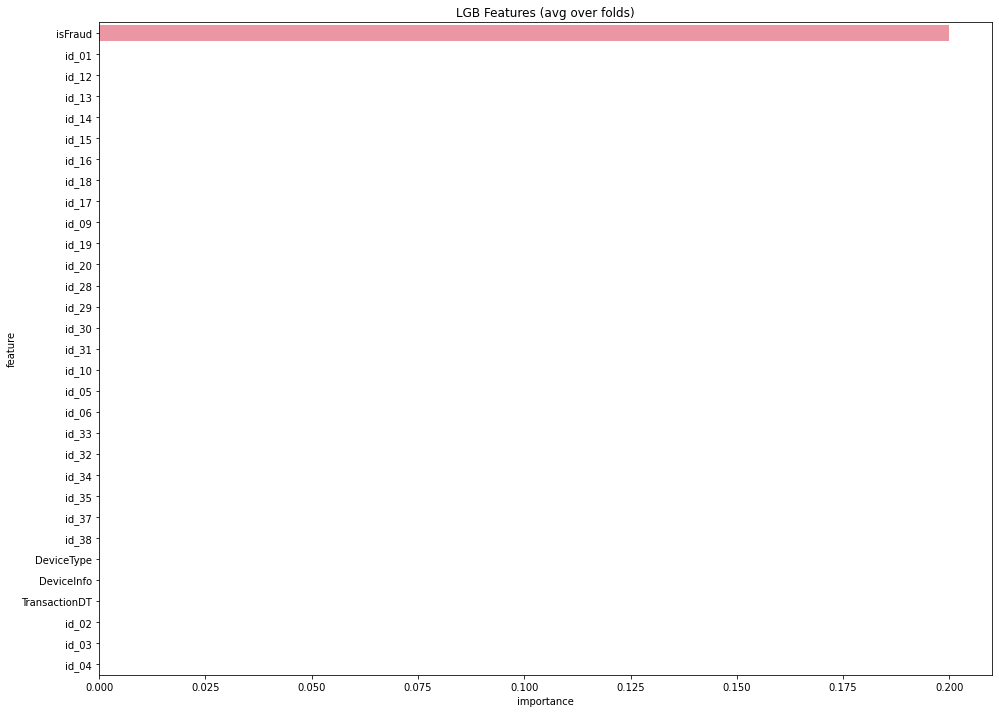

In [33]:
n_fold = 5
folds = TimeSeriesSplit(n_splits=n_fold)
folds = KFold(n_splits=5)
params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          #'categorical_feature': cat_cols
         }


result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='usual', n_jobs=-1)

In [32]:
sub['isFraud'] = result_dict_lgb['prediction']

ValueError: Length of values (141907) does not match length of index (506691)